<a href="https://colab.research.google.com/github/bobbercheng/ventilator-pressure-prediction/blob/master/petfinder_fastai_kf_11_norm_s13_random_boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Petfinder.my - Pawpularity Contest: Simple EDA and fastai starter

In this competition, we will use machine learning to predict the "pawpularity" of a pet using images and metadata. If successful, solutions will be adapted into AI tools that will guide shelters and rescuers around the world to improve the appeal of their pet profiles, automatically enhancing photo quality and recommending composition improvements. As a result, stray dogs and cats can find families much faster, and these tools will help improve animal welfare.

In this notebook, I will present a quick 'n dirty EDA and a (image-only, for now) fastai starter. 

**As of 10/26, it's currently the best-scoring notebook for the competition, beating 10-fold ensemble models that are bigger while only using a single and smaller model.**

V0: Change get_data(fold) to correct K-Fold, use is_valid for validation data
V0: change K-Fold to 11

V1: use cleaned dataset 0fold CV:16.225714855

V3: dropped images has 100 Pawpularity

V4: add BCEWithLogitsLossFlatWeight to set different weight for different class

V5: test different weights


Here is the rmse in different bins for fold 0 for our best model

Fold 0 | Score: 17.45813597262292\
bin 0 cv: 37.49209602111998\
bin 1 cv: 22.772208169008607\
bin 2 cv: 13.207977427382245\
bin 3 cv: 10.522804120560147\
bin 4 cv: 8.483168163797071\
bin 5 cv: 9.485671151318567\
bin 6 cv: 11.804965067115697\
bin 7 cv: 15.564434605405175\
bin 8 cv: 18.247221142730872\
bin 9 cv: 23.35765871546634\
bin 10 cv: 31.41751025239491\
bin 11 cv: 35.20542376392687\
bin 12 cv: 39.36972325654612\
bin 13 cv: 43.24318517984522

Here is the rmse in different bin for fold 0 if I apply weight as norm_score * 100

Fold 0 | Score: 18.592372146023237\
bin 0 cv: 44.05764906073716\
bin 1 cv: 28.184224977673757\
bin 2 cv: 17.87528334312377\
bin 3 cv: 15.530264285947883\
bin 4 cv: 12.524930627037255\
bin 5 cv: 12.766057617128045\
bin 6 cv: 12.442131854766735\
bin 7 cv: 12.350161312759775\
bin 8 cv: 14.791775884854397\
bin 9 cv: 17.55045425213173\
bin 10 cv: 25.36814697660495\
bin 11 cv: 27.56101416173055\
bin 12 cv: 30.351763733535304\
bin 13 cv: 33.257458912599766\

If I set weight only for bin 13 like:
        weight = torch.where(weight >= 93, 30, 1)
The result is

Fold 0 | Score: 23.954549314305204\
bin 0 cv: 53.36884523690475\
bin 1 cv: 35.6026245439023\
bin 2 cv: 23.641181526441343\
bin 3 cv: 22.686988182680597\
bin 4 cv: 19.547315548671225\
bin 5 cv: 21.731360981274825\
bin 6 cv: 20.46953579887746\
bin 7 cv: 17.563321793279\
bin 8 cv: 17.185965318359507\
bin 9 cv: 16.80244003243514\
bin 10 cv: 24.518560469789914\
bin 11 cv: 22.199209214749857\
bin 12 cv: 24.355108733215193\
bin 13 cv: 24.449208502609913

If I set weight = torch.where(weight >= 93, 512, 1), I got very good rmsp for bin 11-13 as following:

Fold 0 | Score: 48.74278342925127\
bin 0 cv: 80.58898903204448\
bin 1 cv: 66.79452060481921\
bin 2 cv: 57.446016762789775\
bin 3 cv: 52.970257956221815\
bin 4 cv: 48.60457566314422\
bin 5 cv: 46.099067746755104\
bin 6 cv: 40.55932192012693\
bin 7 cv: 35.27638789027249\
bin 8 cv: 30.567799892895714\
bin 9 cv: 25.14620826375468\
bin 10 cv: 18.789601181269767\
bin 11 cv: 12.719151272973464\
bin 12 cv: 6.599604111712022\
bin 13 cv: 7.356627632656249


In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
  from google.colab import drive
  drive.mount("/gdrive", force_remount=True)
  !sudo apt-get install sshfs
  !mkdir models_remote
  !mkdir -p ~/.ssh
  !ssh-keyscan 140.238.135.201 >> ~/.ssh/known_hosts
  !sudo sshfs -o allow_other,default_permissions,IdentityFile=/gdrive/MyDrive/kaggle/ssh-key-2021-12-29-kaggle.key opc@140.238.135.201:/models/s13r models_remote


Mounted at /gdrive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
sshfs is already the newest version (2.8-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
mkdir: cannot create directory ‘models_remote’: File exists
# 140.238.135.201:22 SSH-2.0-OpenSSH_7.4
# 140.238.135.201:22 SSH-2.0-OpenSSH_7.4
# 140.238.135.201:22 SSH-2.0-OpenSSH_7.4
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [3]:
if IN_COLAB:
  # !pip install -Uqq fastcore --upgrade
  !pip install --upgrade fastai==2.5.2

In [4]:
!pip show fastai

Name: fastai
Version: 2.5.2
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai/tree/master/
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: matplotlib, pandas, fastprogress, torch, pip, pyyaml, scikit-learn, torchvision, spacy, requests, pillow, packaging, fastdownload, fastcore, scipy
Required-by: 


In [5]:
if IN_COLAB:
  !pip uninstall -y kaggle
  !pip install kaggle
  !mkdir /root/.kaggle
  !cp /gdrive/MyDrive/kaggle/kaggle.json /root/.kaggle
  !kaggle competitions download -c petfinder-pawpularity-score
  !mkdir -p ../input/petfinder-pawpularity-score
  !unzip -n -qq 'petfinder-pawpularity-score.zip' -d ../input/petfinder-pawpularity-score

  !kaggle datasets download -d  tanlikesmath/swin-transformer
  !mkdir -p ../input/swin-transformer
  !unzip -n -qq swin-transformer.zip -d ../input/swin-transformer

  !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
  !mkdir -p ../input/timm-pytorch-image-models
  !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

  # !kaggle datasets download -d  petfinder30folds
  # !mkdir -p ../input/petfinder30folds
  # !unzip -n -qq petfinder30folds.zip -d ../input/petfinder30folds

  # !rm models
  # !mkdir -p /gdrive/MyDrive/kaggle/petfinder/models-s12
  # !ln -s /gdrive/MyDrive/kaggle/petfinder/models-s12 models
  # !mkdir models

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
  Using cached kaggle-1.5.12-py3-none-any.whl
mkdir: cannot create directory ‘/root/.kaggle’: File exists
petfinder-pawpularity-score.zip: Skipping, found more recently modified local copy (use --force to force download)
swin-transformer.zip: Skipping, found more recently modified local copy (use --force to force download)
timm-pytorch-image-models.zip: Skipping, found more recently modified local copy (use --force to force download)


## A look at the data
Let's start out by setting up our environment by importing the required modules and setting a random seed:

In [6]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
#from timm.data.mixup import Mixup

In [7]:
from fastai.vision.all import *
#from fastai.callback.hook import *

In [8]:
seed=13
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

BATCH_SIZE = 32
NEED_TRAIN = True

Let's check what data is available to us:

In [9]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

(#5) [Path('../input/petfinder-pawpularity-score/sample_submission.csv'),Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/train'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/test')]

We can see that we have our train csv file with the train image names, metadata and labels, the test csv file with test image names and metadata, the sample submission csv with the test image names, and the train and test image folders.

Let's check the train csv file:

In [10]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


The metadata provided includes information about key visual quality and composition parameters of the photos. The Pawpularity Score is derived from the profile's page view statistics. This is the target we are aiming to predict.

Let's do some quick processing of the image filenames to make it easier to access:

In [11]:
# #removed duplicates that has lower score than the same image
# removed_id = ['5ef7ba98fc97917aec56ded5d5c2b099',
#              '1feb99c2a4cac3f3c4f8a4510421d6f5',
#              '5a642ecc14e9c57a05b8e010414011f2',
#              '0422cd506773b78a6f19416c98952407',
#              '9b3267c1652691240d78b7b3d072baf3',
#              '1059231cf2948216fcc2ac6afb4f8db8',
#              '8ffde3ae7ab3726cff7ca28697687a42',
#              '78a02b3cb6ed38b2772215c0c0a7f78e',
#              'bf8501acaeeedc2a421bac3d9af58bb7',
#              'fe47539e989df047507eaa60a16bc3fd',
#              'dd042410dc7f02e648162d7764b50900',
#              '988b31dd48a1bc867dbc9e14d21b05f6',
#              'e359704524fa26d6a3dcd8bfeeaedd2e',
#              '6ae42b731c00756ddd291fa615c822a1',
#              '9a0238499efb15551f06ad583a6fa951',
#              'a9513f7f0c93e179b87c01be847b3e4c',
#              '38426ba3cbf5484555f2b5e9504a6b03',
#              'cd909abf8f425d7e646eebe4d3bf4769',
#              '9f5a457ce7e22eecd0992f4ea17b6107',
#              '3877f2981e502fe1812af38d4f511fd2',
#              'b190f25b33bd52a8aae8fd81bd069888',
#              '94c823294d542af6e660423f0348bf31',
#              '2b737750362ef6b31068c4a4194909ed',
#              '01430d6ae02e79774b651175edd40842',
#              '72b33c9c368d86648b756143ab19baeb',
#              'dbc47155644aeb3edd1bd39dba9b6953',
#              'b49ad3aac4296376d7520445a27726de',
#              '54563ff51aa70ea8c6a9325c15f55399',
#              '87c6a8f85af93b84594a36f8ffd5d6b8',
#              '16d8e12207ede187e65ab45d7def117b']

There are 9912 images
The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.591990105774546


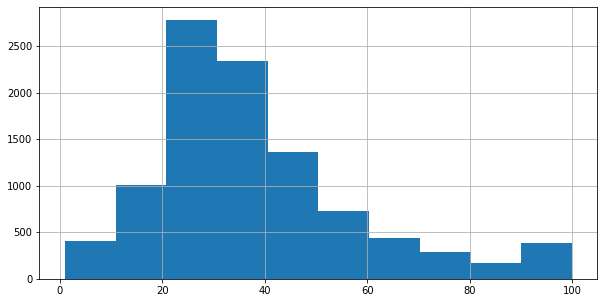

In [12]:
len_df = len(train_df)
print(f"There are {len_df} images")
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [13]:
# train_df_100 = train_df[train_df['Pawpularity']==100].copy()
# rain_df = train_df[train_df['Pawpularity']!=100].copy()

There are 9912 images
The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.591990105774546


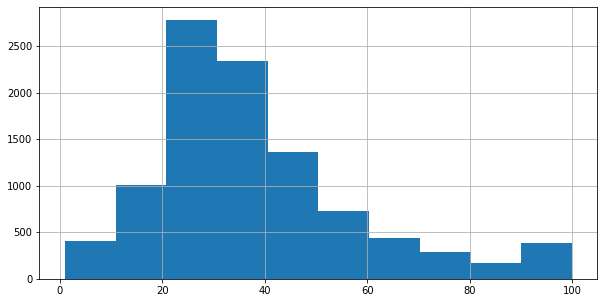

In [14]:
len_df = len(train_df)
print(f"There are {len_df} images")
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [15]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,1,1,1,0,0,0,0,0,0,0,0,29,../input/petfinder-pawpularity-score/train/0e21db5c5be5a8e69c14b72beae133e8.jpg
1,0,0,1,1,0,0,0,0,0,0,0,0,12,../input/petfinder-pawpularity-score/train/99bfa88b01dcf30494b925f5151149a3.jpg
2,0,1,0,1,0,0,0,0,0,0,0,0,12,../input/petfinder-pawpularity-score/train/0422cd506773b78a6f19416c98952407.jpg
3,0,1,1,1,0,0,0,0,0,0,0,0,21,../input/petfinder-pawpularity-score/train/e373d14d745ec02f9781d83ca0084639.jpg
4,0,1,1,1,0,0,0,0,0,0,0,0,83,../input/petfinder-pawpularity-score/train/cf6e40e6734626da4f6985718a2dacb8.jpg


Okay, let's check how many images are available in the training dataset:

Let's check the distribution of the Pawpularity Score:

In [16]:
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

There are 100 unique values of Pawpularity score


Note that the Pawpularity score is an integer, so in addition to being a regression problem, it could also be treated as a 100-class classification problem. Alternatively, it can be treated as a binary classification problem if the Pawpularity Score is normalized between 0 and 1:

In [17]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.29
1       0.12
2       0.12
3       0.21
4       0.83
        ... 
9907    0.15
9908    0.22
9909    0.41
9910    0.53
9911    0.35
Name: norm_score, Length: 9912, dtype: float64

Let's check an example image to see what it looks like:

In [18]:
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

720 960


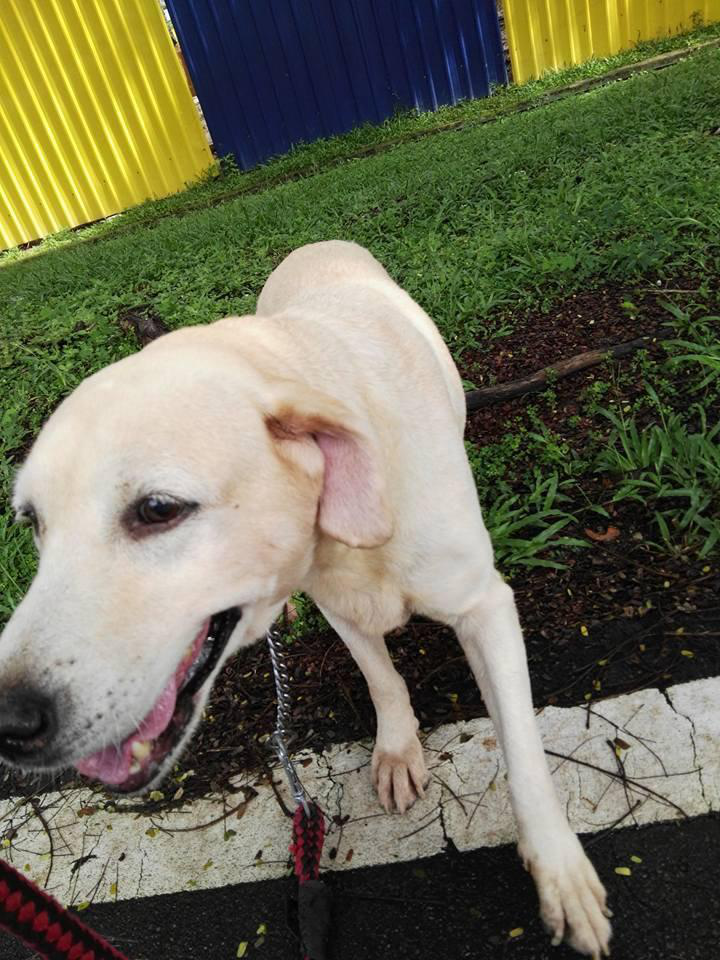

In [19]:
im

## Data loading
After my quick 'n dirty EDA, let's load the data into fastai as DataLoaders objects. We're using the normalized score as the label. I use some fairly basic augmentations here.

In [20]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [21]:
#Sturges' rule
num_bins = int(np.floor(1+np.log2(len(train_df))))
num_bins

14

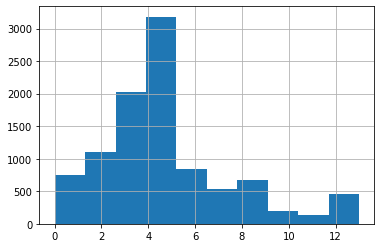

In [22]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

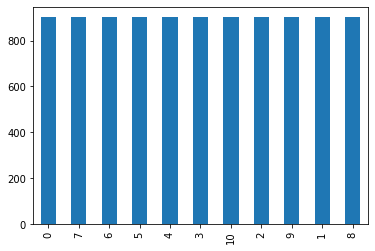

In [23]:
#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 11
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [24]:
train_df[train_df['fold']==0].head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
13,0,0,1,1,0,0,0,0,0,0,0,1,22,../input/petfinder-pawpularity-score/train/2b5a8930864f1e10d1df094f9b8bc86c.jpg,0.22,2,0
23,0,1,1,1,0,0,0,0,1,0,0,0,18,../input/petfinder-pawpularity-score/train/3a66d46585bdfb277e7b41ba9fe07c97.jpg,0.18,2,0
24,0,1,1,0,0,0,0,1,0,0,0,0,21,../input/petfinder-pawpularity-score/train/6737ffdb56858ecefa870ca646f22059.jpg,0.21,2,0
28,1,1,1,1,0,0,0,0,0,0,0,0,55,../input/petfinder-pawpularity-score/train/b6745a3e80c05c47ceb7ef2738acc9c7.jpg,0.55,7,0
59,0,1,1,1,0,0,0,0,0,0,0,0,28,../input/petfinder-pawpularity-score/train/b5dd2c5068363fef61de2cdb27be7cd2.jpg,0.28,3,0


In [25]:
train_df[train_df['fold']==0]['bins'].value_counts()

3     185
4     171
5     118
2     100
6      76
7      49
1      38
8      37
13     32
0      30
9      25
10     18
11     13
12     10
Name: bins, dtype: int64

In [26]:
train_df[train_df['fold']==1]['bins'].value_counts()

3     185
4     171
5     118
2     100
6      76
7      49
1      38
8      36
13     33
0      30
9      25
10     18
11     13
12      9
Name: bins, dtype: int64

In [27]:
def petfinder_rmse(input,target):
    # print('target shape', target.shape)
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [28]:
# # mixup_fn = Mixup(**mixup_args)

# mixup_args = {
#     'mixup_alpha': 1.,
#     'cutmix_alpha': 0.,
#     'cutmix_minmax': None,
#     'prob': 1.0,
#     'switch_prob': 0.,
#     'mode': 'batch',
#     'label_smoothing': 0,
#     'num_classes': 1000}

# dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
#                 get_x=ColReader('path'),
#                 get_y=ColReader('norm_score'),
#                 splitter=RandomSplitter(0.2),
#                 item_tfms=Resize(224), #pass in item_tfms
#                 batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
#                )
    
# dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
# #                                valid_pct=0.2, #80-20 train-validation random split
#                                valid_col='is_valid', #
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_col='norm_score', #label is in the first column of the DataFrame
#                                y_block=RegressionBlock, #The type of target
#                                bs=BATCH_SIZE, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

In [29]:
# paw_dls = dls.dataloaders(train_df, 
#                           bs=BATCH_SIZE,
#                           num_workers=8,
#                           seed=seed)
# paw_dls.show_batch()

In [30]:
# len(paw_dls.train.dataset), len(paw_dls.valid.dataset)

In [31]:
# model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=paw_dls.c)

# learn = Learner(paw_dls,
#                 model,
#                 loss_func=BCEWithLogitsLossFlat(),
#                 metrics=petfinder_rmse,
#                 cbs=[MixUp(0.2)]).to_fp16()

In [32]:
# learn.lr_find(end_lr=3e-2)

In [33]:
# learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 

# learn.recorder.plot_loss()
        
        
#         learn.unfreeze()
        
#         learn.fit_one_cycle(5,lr_max=slice(1e-6,1e-4))


In [34]:
def get_data(fold, train_df_f=train_df):
    # train_df_f = train_df.copy()
    # add is_valid for validation fold
    # train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    # It looks if seed of RandomSplitter is set, it reduce the score. So we don't set seed here
    splitter = RandomSplitter(0.2)

    validate_idx = splitter(range(len(train_df_f)))[1]
    #find pawpularity 100
    # idx_100 = train_df.loc[train_df['Pawpularity']==100].index

    # Add pawpularity 100 here
    # validate_idx = list(set(validate_idx).union(set(idx_100)))

    # print(validate_idx)
    # print(f'validat dataset size is {len(validate_idx)} including {len(idx_100)} images with pawpularity 100')

    # Change RandomSplitter to IndexSplitter
    splitter = IndexSplitter(validate_idx)
    
    dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader('path'),
                get_y=ColReader('norm_score'),
                splitter=splitter,
                item_tfms=Resize(224), #pass in item_tfms
                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation(),
                                           RandomErasing(p=1., max_count=6),
                                           Normalize.from_stats(*imagenet_stats)])
               )
    
    train_idx = splitter(range(len(train_df_f)))[0]

    only_train_df = train_df_f.loc[train_idx]
    bin12_df = only_train_df.loc[only_train_df['bins']==12]
    bin11_df = only_train_df.loc[only_train_df['bins']==11]
    bin10_df = only_train_df.loc[only_train_df['bins']==10]


    train_df_f_boost = pd.concat([train_df_f, bin10_df, bin11_df, bin11_df, bin12_df, bin12_df], ignore_index=True)
    print(f'train_df_f_boost: {len(train_df_f_boost)}, bin12: {len(bin12_df)}, bin11: {len(bin11_df)}, bin10: {len(bin10_df)}')
   
    paw_dls = dls.dataloaders(train_df_f_boost, 
                          bs=BATCH_SIZE,
                          num_workers=8,
                          seed=seed)
    
    return paw_dls, splitter


In [35]:
# mixup_args = {
#     'mixup_alpha': 1.,
#     'cutmix_alpha': 0.,
#     'cutmix_minmax': None,
#     'prob': 1.0,
#     'switch_prob': 0.,
#     'mode': 'batch',
#     'label_smoothing': 0,
#     'num_classes': 1000}

In [36]:
#Valid Kfolder size
# the_data, splitter = get_data(0)
# assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [37]:
@delegates()
class BCEWithLogitsLossFlatWeight(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

    def __call__(self, inp, targ, **kwargs):
        # print(f'input shape: {inp.shape}, target shape: {targ.shape}')
        # Set weight for all targets
#         weight = targ * 100
#         # Only set weight for bin 13
#         weight = torch.where(weight >= 93, 512, 1)
        #self.func.register_buffer('weight', weight)
        # print(f'weight: {weight}')
        return super().__call__(inp, targ, **kwargs)

In [38]:
def get_learner(fold_num):
    data, splitter = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    loss = BCEWithLogitsLossFlatWeight()
    

    learn = Learner(data, model, loss_func=loss, metrics=petfinder_rmse, cbs=[MixUp(0.2)]).to_fp16()
    
    return learn, splitter

In [39]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [40]:
if len(test_df) != 8:
    NEED_TRAIN = True

In [41]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [42]:
# if NEED_TRAIN:
#     get_learner(fold_num=0).lr_find(end_lr=3e-2)

In [43]:
import gc

In [44]:
from sklearn.metrics import mean_squared_error
def get_cv_for_bins(bins, pred_col='pred'):
  cv_score = mean_squared_error(train_df.loc[(train_df[pred_col]!=-1) & (train_df['bins']==bins), 'Pawpularity'], 
                                train_df.loc[(train_df[pred_col]!=-1) & (train_df['bins']==bins), pred_col], squared=False)
  return cv_score


def print_cv_for_all_bins(pred_col='pred', num_bins=13):
  cv_scores = []
  for bins in range(num_bins):
    cv = get_cv_for_bins(bins, pred_col)
    print(f'bin {bins} cv: {cv}')
    cv_scores.append(cv)

  cv_score = mean_squared_error(train_df.loc[(train_df[pred_col]!=-1), 'Pawpularity'], 
                                train_df.loc[(train_df[pred_col]!=-1), pred_col], squared=False)
  print(f'total cv:{cv_score}')
  return cv_scores

In [45]:
skip_range = range(10)

if NEED_TRAIN:
    all_preds = []
    train_df['pred'] = -1

    for i in range(N_FOLDS):
        if i in skip_range:
            continue

        print(f'Fold {i} results')

        learn, splitter = get_learner(fold_num=i)
        
#         mixup_args = {
#             'mixup_alpha': 1.,
#             'cutmix_alpha': 0.,
#             'cutmix_minmax': None,
#             'prob': 1.0,
#             'switch_prob': 0.,
#             'mode': 'batch',
#             'label_smoothing': 0,
#             'num_classes': 100}
        
#         mixup_fn = Mixup(**mixup_args)

        learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 

        # learn.recorder.plot_loss()

        learn.export(f'models_remote/model_fold_{i}.pkl')


        paw_dls = learn.dls
        
        test_dl = paw_dls.test_dl(test_df)

        preds, _ = learn.tta(dl=test_dl, n=10, beta=0)

        all_preds.append(preds)
        
        #Only do CV for public train
        if len(test_df) == 8:
            val_idx = splitter(range(len(train_df)))[1]
            # Save validation idx here
            np.save(f'models_remote/val_idx_{i}', val_idx)
            val_df = train_df.loc[val_idx]
            val_pred, _ = learn.tta(dl=paw_dls.test_dl(val_df), n=10, beta=0)
            print(val_df['Pawpularity'][:5], val_pred[:5])
            score = mean_squared_error(val_df['Pawpularity'], val_pred*100, squared=False)
            print(f'Fold {i} | Score: {score}')
            # Save prediction of validation as pred
            train_df.loc[val_idx, 'pred'] = val_pred*100
            
            print_cv_for_all_bins()
            
            del val_pred
        
            

        del learn

        torch.cuda.empty_cache()

        gc.collect()
        
        #Only run one fold for public train as we don't have so many GPU time
#         if len(test_df) == 8 and (not IN_COLAB):
#             break
    if len(test_df) == 8:
        cv_score = mean_squared_error(train_df.loc[train_df['pred']!=-1, 'Pawpularity'], 
                                      train_df.loc[train_df['pred']!=-1, 'pred'], squared=False)
        print(f'CV Score: {cv_score}')

Fold 10 results
train_df_f_boost: 10465, bin12: 87, bin11: 112, bin10: 155


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.662237,0.650420,18.802607,05:39
1,0.652364,0.639666,17.334215,05:35
2,0.646609,0.639311,17.237268,05:35
3,0.639163,0.642147,17.615517,05:35
4,0.633890,0.642225,17.616531,05:35


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6504201292991638.
Better model found at epoch 1 with valid_loss value: 0.6396659016609192.
Better model found at epoch 2 with valid_loss value: 0.6393108367919922.
No improvement since epoch 2: early stopping


1186    21
5330    32
7166    47
9662    58
2026    22
Name: Pawpularity, dtype: int64 tensor([[0.2268],
        [0.2878],
        [0.2704],
        [0.5261],
        [0.3389]])
Fold 10 | Score: 17.36791190216963
bin 0 cv: 37.44356128545196
bin 1 cv: 20.516653062379945
bin 2 cv: 15.079361367828387
bin 3 cv: 10.6096469896457
bin 4 cv: 8.869290673476504
bin 5 cv: 10.367282814870567
bin 6 cv: 10.930625202517287
bin 7 cv: 14.997082373642716
bin 8 cv: 18.149289031257705
bin 9 cv: 21.84922445380167
bin 10 cv: 27.75707659982586
bin 11 cv: 34.92613016039412
bin 12 cv: 37.50067079337847
total cv:17.36791190216963
CV Score: 17.36791190216963


In [46]:
if NEED_TRAIN:
    all_preds, np.mean(np.stack(all_preds*100))

In [47]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
if NEED_TRAIN:
    preds = np.mean(np.stack(all_preds), axis=0)
    sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [48]:
if not NEED_TRAIN:
    pd.read_csv('submission.csv').head()

In [49]:
# save CV prediction
train_df.to_csv('train_df.csv',index=False)

# Model training

Let's train a Swin Transformer model as a baseline. We will use the wonderful timm package by Ross Wightman to define the model. Since this competition doesn't allow internet access, I have added the pretrained weights from timm as a dataset, and the below code cell will allow timm to find the file:

Let's now define the model.

Let's also define the metric we will use. Note that we multiply by 100 to get a relevant RMSE for Pawpularity Score prediction, not prediction of the normalized score.

In fastai, the trainer class is the `Learner`, which takes in the data, model, optimizer, loss function, etc. and allows you to train models, make predictions, etc. Let's define the `Learner` for this task, and also use mixed precision. Note that we use `BCEWithLogitsLoss` to treat this as a classification problem.

We are now provided with a Learner object. In order to train a model, we need to find the most optimal learning rate, which can be done with fastai's learning rate finder:

lrは上記のコードから提案された値に変更する

Let's now fine-tune the model with the desired learning rate of 2e-5. We'll save the best model and use the early stopping callback.

We plotted the loss, put the model back to fp32, and now we can export the model if we want to use later (i.e. for an inference kernel):

## Inference

It's very simple to perform inference with fastai. We preprocess the test CSV in the same way as the train CSV, and the `dls.test_dl` function allows you to create test dataloader using the same pipeline we defined earlier.

We can easily confirm that the test_dl is correct (the example test images provided are just noise so this is expected):

Now let's pass the dataloader to the model and get predictions. Here I am using 5x test-time augmentation which further improves model performance.

Let's make a submission with these predictions!

In [50]:
# sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
# sample_df['Pawpularity'] = preds.float().numpy()*100
# sample_df.to_csv('submission.csv',index=False)

Now, **WE ARE DONE!**

If you enjoyed this notebook, please give it an upvote. 

Stay tuned for improvements to this notebook, potentially including a version that uses the metadata as well.

If you have any questions or suggestions, please leave a comment!